In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import linear_model 
import category_encoders as ce
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.imputation import CategoricalImputer
     
     
#train-test split, imputers, transformers, encoders
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer,IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder, StandardScaler,OneHotEncoder
#models
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,VotingRegressor, StackingRegressor
#notebooks
import warnings
warnings.filterwarnings('ignore')




## Identifying the dataset



In [ ]:
df_test=pd.read_csv('test.csv')
# Y_test=pd.read_csv("sample_submission.csv")
# Y_test=Y_test['SalePrice']
df_train=pd.read_csv('train.csv')


# df_test.drop('Id',axis=1,inplace=True)
# Y_train=df_train['SalePrice']
# df_train.drop(['Id','SalePrice'],axis=1,inplace=True)
# df_train.describe()
#same shape (to avoid problems in ML model):
# rand=np.random.randint(1460)
# df_train.drop(rand,inplace=True)
# Y_train.drop(rand,inplace=True)
plt.hist(x='SalePrice',data=df_train,bins=70)
plt.show()

In [ ]:
def idfy_cols(df):
    #missed = df.loc[:, df.isna().any()]
    total =df.columns
    categorical = df.dtypes == 'object'
    # Reindex the boolean series to match the dataframe columns
    categorical = categorical.reindex(total, fill_value=False)
    categorical = df.loc[:, categorical].columns
    numerical = total.difference(categorical)
    return categorical, numerical
#Total cols
cat,num=idfy_cols(df_test)
print("# Total Of Categorical Cols:",cat.shape[0],"\n# Total Of Numerical Cols:",num.shape[0])
#None cols
cat_train,num_train=idfy_cols(df_train.loc[:, df_train.isna().any()])
print(df_train.value_counts())
total=len(df_train)
cat_ncols_train=df_train[cat_train].isnull().sum()*100/total
num_ncols_train=df_train[num_train].isnull().sum()*100/total
print("Nan Cathegorical (%)")
cat_ncols_train.sort_values(ascending=False)

In [ ]:
print("Nan Numerical (%)")
num_ncols_train.sort_values(ascending=False)

In [ ]:
#the NaN values on MasVnrArea occur when there's no MasVnr, hence 0
df_train['MasVnrArea']=df_train['MasVnrArea'].fillna(0)
df_test['MasVnrArea']=df_test['MasVnrArea'].fillna(0)
#the NaN values on GarageYrBlt occur when there's no arange, hence 0
df_train['GarageYrBlt']=df_train['GarageYrBlt'].fillna(0)
df_test['GarageYrBlt']=df_test['GarageYrBlt'].fillna(0)

## Removing Outliers

Categorical

In [ ]:
# # ['PoolQC','MiscFeature','Alley','Fence','MasVnrType']
for col in cat:
    df_train[col].fillna('NA',inplace=True)
    df_test[col].fillna('NA',inplace=True)
    plt.figure(figsize=(20,12))
    sns.violinplot(data=df_train,x=col,y='SalePrice')
    plt.title("SalePrices vs {col}".format(col=col),fontsize=25)
    plt.show()
    print(df_train[col].value_counts()/len(df_train))

In [ ]:
df_train.drop(columns=["Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature","Utilities","Street","Heating","PavedDrive"],axis=1,inplace=True)
df_test.drop(columns=["Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature","Utilities","Street","Heating","PavedDrive"],axis=1,inplace=True)
df_train.BsmtQual=df_train.BsmtQual.replace('NA','Fa')

df_train.Electrical=df_train.Electrical.replace('NA','SBrkr')
df_test.Electrical=df_test.Electrical.replace('NA','SBrkr')

df_train.GarageFinish=df_train.GarageFinish.replace('NA','Unf')
df_test.GarageFinish=df_test.GarageFinish.replace('NA','Unf')

df_train.GarageQual=df_train.GarageQual.replace('NA','Po')
df_test.GarageQual=df_test.GarageQual.replace('NA','Po')

df_train.GarageCond=df_train.GarageCond.replace('NA','Po')
df_test.GarageCond=df_test.GarageCond.replace('NA','Po')


df_train.RoofMatl=df_train.RoofMatl.replace(['Metal','Membran','Roll','ClyTile'],'Other')
df_test.RoofMatl=df_test.RoofMatl.replace(['Metal','Membran','Roll','ClyTile'],'Other')
#condition 1
df_train.Condition1=df_train.Condition1.replace(['PosA','RRNn','RRNe'],'Other')
df_test.Condition1=df_train.Condition1.replace(['PosA','RRNn','RRNe'],'Other')
#condition 2
df_train.Condition2=df_train.Condition1.replace(['PosA','RRAn','RRAe'],'Other')
df_test.Condition2=df_train.Condition1.replace(['PosA','RRAn','RRAe'],'Other')
#exterior
df_train['Exterior']=df_train.Exterior1st+df_train.Exterior2nd
df_test['Exterior']=df_test.Exterior1st+df_test.Exterior2nd

df_train.drop(columns=['Exterior1st','Exterior2nd'],inplace=True)
df_test.drop(columns=['Exterior1st','Exterior2nd'],inplace=True)


Numerical

In [ ]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]

In [ ]:
plt.scatter(x='MSSubClass',y='SalePrice',data=df_train)

In [ ]:
plt.scatter(x='LotFrontage',y='SalePrice',data=df_train)
df_train.query('LotFrontage >300')
# 934,1298


In [ ]:
plt.scatter(x='LotArea',y='SalePrice',data=df_train)
df_train.query('LotArea >300').sort_values('LotArea')
# since 452


In [ ]:
plt.scatter(x='OverallQual',y='SalePrice',data=df_train)
df_train.query('OverallQual==10').sort_values(by='SalePrice')
#523,1298,457,770

In [ ]:
plt.scatter(x='OverallCond',y='SalePrice',data=df_train)
df_train.query('OverallCond==2').sort_values(by='SalePrice')
#379,1183,692

In [ ]:

plt.scatter(x='YearBuilt',y='SalePrice',data=df_train)
df_train.query('YearBuilt<1900 & YearBuilt>1850').sort_values(by='SalePrice')
df_train.query('YearBuilt<2000 & YearBuilt>1980').sort_values(by='SalePrice')
#186,1183,692

In [ ]:
plt.scatter(x='YearRemodAdd',y='SalePrice',data=df_train)
# df_train.query('YearRemodAdd>1980 & YearRemodAdd<2000').sort_values(by='SalePrice')
df_train.query('YearRemodAdd<2000 & YearRemodAdd>1920').sort_values(by='SalePrice')
#1183,692

In [ ]:
plt.scatter(x='MasVnrArea',y='SalePrice',data=df_train)
df_train.query('MasVnrArea==0').sort_values(by='SalePrice')
df_train[df_train.MasVnrArea==0]['MasVnrArea'].value_counts()/len(df_train)
#1183

In [ ]:
plt.scatter(x='BsmtFinSF1',y='SalePrice',data=df_train)
df_train.query('BsmtFinSF1>5000').sort_values(by='SalePrice')
df_train[df_train.BsmtFinSF1==0]['BsmtFinSF1'].value_counts()/len(df_train)
#1299

In [ ]:

plt.scatter(x='BsmtFinSF2',y='SalePrice',data=df_train)
df_train.query('BsmtFinSF2==0').sort_values(by='SalePrice')
df_train[df_train.BsmtFinSF2==0]['BsmtFinSF2'].value_counts()/len(df_train)
#323,1183,692

In [ ]:

plt.scatter(x='BsmtUnfSF',y='SalePrice',data=df_train)
df_train[df_train.BsmtUnfSF==0]['BsmtUnfSF'].value_counts()/len(df_train)

In [ ]:
plt.scatter(x='TotalBsmtSF',y='SalePrice',data=df_train)
df_train[df_train.TotalBsmtSF==0]['TotalBsmtSF'].value_counts()/len(df_train)
#1299

In [ ]:
plt.scatter(x='1stFlrSF',y='SalePrice',data=df_train)
df_train.sort_values(by='1stFlrSF',ascending=False)
#1299

In [ ]:
plt.scatter(x='LowQualFinSF',y='SalePrice',data=df_train)
df_train.query('LowQualFinSF==0').sort_values(by='SalePrice')
df_train[df_train.LowQualFinSF==0]['LowQualFinSF'].value_counts()/len(df_train)

In [ ]:
df_train.drop(columns=['LowQualFinSF'],inplace=True)
df_test.drop(columns=['LowQualFinSF'],inplace=True)

In [ ]:
plt.scatter(x='GrLivArea',y='SalePrice',data=df_train)
df_train.query('GrLivArea>4000').sort_values(by='SalePrice')
#524,692

In [ ]:
plt.scatter(x='BsmtFullBath',y='SalePrice',data=df_train)
df_train.query('BsmtFullBath==1').sort_values(by='SalePrice')
df_train.query('BsmtFullBath==0').sort_values(by='SalePrice')
#692,1183

In [ ]:
df_train.BsmtFullBath=df_train.BsmtFullBath.replace(3,-1)

In [ ]:
plt.scatter(x='BsmtHalfBath',y='SalePrice',data=df_train)
df_train.query('BsmtHalfBath==2').sort_values(by='SalePrice')
#955,598

In [ ]:
df_train.BsmtHalfBath=df_train.BsmtHalfBath.replace(2,-1)

In [ ]:
plt.scatter(x='BedroomAbvGr',y='SalePrice',data=df_train)
df_train.query('BedroomAbvGr==8').sort_values(by='SalePrice')
#636    

In [ ]:
df_train.BedroomAbvGr=df_train.BedroomAbvGr.replace(8,-1)

In [ ]:
plt.scatter(x='KitchenAbvGr',y='SalePrice',data=df_train)
df_train.query('KitchenAbvGr==0 or KitchenAbvGr==3 ').sort_values(by='SalePrice')
#49,810,955

In [ ]:
df_train.KitchenAbvGr=df_train.KitchenAbvGr.replace([0,3],-1)

In [ ]:
plt.scatter(x='TotRmsAbvGrd',y='SalePrice',data=df_train)
df_train.query('TotRmsAbvGrd==14').sort_values(by='SalePrice')
df_train.groupby('TotRmsAbvGrd')['SalePrice'].mean().sort_values(ascending=False)
df_train.TotRmsAbvGrd.value_counts()/len(df_train)
#636

In [ ]:
df_train.TotRmsAbvGrd=df_train.TotRmsAbvGrd.replace(14,-1)

In [ ]:
plt.scatter(x='Fireplaces',y='SalePrice',data=df_train)


In [ ]:
df_train.Fireplaces=df_train.Fireplaces.replace(3,-1)

In [ ]:
df_train.GarageYrBlt=df_train.GarageYrBlt.replace(0,1900)
plt.scatter(x='GarageYrBlt',y='SalePrice',data=df_train)
df_train[df_train.GarageYrBlt==0]['GarageYrBlt'].value_counts()/len(df_train)

In [ ]:
plt.scatter(x='GarageCars',y='SalePrice',data=df_train)
df_train.groupby('GarageCars')['SalePrice'].mean()
df_train.query('GarageCars==4').sort_values(by='SalePrice')


In [ ]:
df_train.GarageCars=df_train.GarageCars.replace(4,-1)

In [ ]:
plt.scatter(x='GarageArea',y='SalePrice',data=df_train)
df_train.query('GarageArea>1200').sort_values(by='SalePrice')
#582,1191,1062

In [ ]:
plt.scatter(x='OpenPorchSF',y='SalePrice',data=df_train)
df_train.query('OpenPorchSF>500').sort_values(by='SalePrice')
#496,1329,584


In [ ]:
plt.scatter(x='WoodDeckSF',y='SalePrice',data=df_train)
df_train.query('WoodDeckSF>800').sort_values(by='SalePrice')
#54
df_train[df_train.WoodDeckSF==0]['WoodDeckSF'].value_counts()/len(df_train)

In [ ]:
plt.scatter(x='EnclosedPorch',y='SalePrice',data=df_train)
df_train.query('EnclosedPorch>500').sort_values(by='SalePrice')
df_train[df_train.EnclosedPorch==0]['EnclosedPorch'].value_counts()/len(df_train)

In [ ]:
plt.hist(x=df_train[df_train.EnclosedPorch==0]['SalePrice'],bins=70)
plt.show()


In [ ]:
plt.scatter(x='3SsnPorch',y='SalePrice',data=df_train)
df_train[df_train['3SsnPorch']==0]['3SsnPorch'].value_counts()[0]/len(df_train)


In [ ]:
df_train.drop(columns=["3SsnPorch"],inplace=True)
df_test.drop(columns=["3SsnPorch"],inplace=True)



In [ ]:
plt.scatter(x='ScreenPorch',y='SalePrice',data=df_train)
df_train[df_train.ScreenPorch==0]['ScreenPorch'].value_counts()/len(df_train)

In [ ]:
plt.scatter(x='PoolArea',y='SalePrice',data=df_train)
df_train[df_train.PoolArea==0]['PoolArea'].value_counts()/len(df_train)


In [ ]:
df_train.drop(columns=["PoolArea"],inplace=True)
df_test.drop(columns=["PoolArea"],inplace=True)

In [ ]:

plt.scatter(x='MiscVal',y='SalePrice',data=df_train)
df_train.query('MiscVal>6000').sort_values(by='SalePrice')
df_train[df_train.MiscVal==0]['MiscVal'].value_counts()/len(df_train)

#347 1231


In [ ]:
df_train.drop(columns=["MiscVal"],inplace=True)
df_test.drop(columns=["MiscVal"],inplace=True)

In [ ]:
plt.scatter(x='YrSold',y='SalePrice',data=df_train)
df_train.query('YrSold==2007').sort_values(by='SalePrice')
df_train.query('YrSold==2010').sort_values(by='SalePrice')
#692,1183,770,899	

In [ ]:
fig,ax1=plt.subplots()
ax1.set_xlabel("LotFrontage")
ax1.scatter(x=df_train['LotFrontage'],y=df_train['SalePrice'],label='LotFrontage', color='blue')
ax2=ax1.twiny()
ax2.set_xlabel("LotArea")
ax2.scatter(x=df_train['LotArea'],y=df_train['SalePrice'], label='LotArea', color='green')

# Add labels and title
plt.ylabel('Sale Price')
plt.title('Sale Price vs Lot Features (Colored)')


Finding if there's correlation between them:

In [ ]:
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
nan_values= df_train['LotFrontage'].isna()
X=df_train['LotArea'][-nan_values]
y=df_train['LotFrontage'][-nan_values]

xy=pd.concat([X,y],axis=1)

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1
outlier_bounds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
print(xy.shape)
xy= xy[xy['LotArea'].between(*outlier_bounds)]
x=xy['LotFrontage'].values.reshape(-1, 1)
y=xy['LotArea'].values.reshape(-1, 1)

for regr in [LinearRegression(),Lasso(),Ridge(),ElasticNet()]:
    regr=regr.fit(x,y)
    y_pred=regr.predict(x)
    print(r2_score(y,y_pred))

#<0.5

In [ ]:
delete_ids=[770, 523, 524, 1298, 1299, 1183, 934, 1191, 1062, 810, 49, 1329, 692, 54, 186, 955, 314, 707, 452, 323, 582, 584, 457, 336, 598, 496, 250, 379, 636]

df_train.drop(df_train[df_train.Id.isin(delete_ids)].index, inplace=True)

Feature Engineering (reducing columns)

In [ ]:
df_train['houseage'] = df_train['YrSold'] - df_train['YearBuilt']
df_test['houseage'] = df_test['YrSold'] - df_test['YearBuilt']
df_train['houseremodelage'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_test['houseremodelage'] = df_test['YrSold'] - df_test['YearRemodAdd']
df_train['totalsf'] = df_train['1stFlrSF'] + df_train['2ndFlrSF'] + df_train['BsmtFinSF1'] + df_train['BsmtFinSF2']
df_test['totalsf'] = df_test['1stFlrSF'] + df_test['2ndFlrSF'] + df_test['BsmtFinSF1'] + df_test['BsmtFinSF2']
df_train['totalarea'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']
df_test['totalarea'] = df_test['GrLivArea'] + df_test['TotalBsmtSF']
df_train['totalbaths'] = df_train['BsmtFullBath'] + df_train['FullBath'] + 0.5 * (df_train['BsmtHalfBath'] + df_train['HalfBath']) 
df_test['totalbaths'] = df_test['BsmtFullBath'] + df_test['FullBath'] + 0.5 * (df_test['BsmtHalfBath'] + df_test['HalfBath']) 
df_train['totalporchsf'] = df_train['OpenPorchSF'] + df_train['EnclosedPorch'] + df_train['ScreenPorch'] + df_train['WoodDeckSF']
df_test['totalporchsf'] = df_test['OpenPorchSF'] + df_test['EnclosedPorch'] + df_test['ScreenPorch'] + df_test['WoodDeckSF']

df_train.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'],inplace=True)
df_test.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'],inplace=True)

In [ ]:
corr_matrix = df_train.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
def idfyCorrelations(df,maxcorr):
    corr_features=set()
    dfcorr=df.corr(numeric_only=True)
    y=list(dfcorr.columns).index('SalePrice')
    for column in range(len(dfcorr.columns)):
        for row in range(column):
            a=dfcorr.columns[column]
            b=dfcorr.columns[row]
            if dfcorr.iloc[column,row]!=1 and (a!='SalePrice' and b!='SalePrice'):
                if abs(dfcorr.iloc[column,row])>=maxcorr and (abs(dfcorr.iloc[column,y])>=maxcorr or abs(dfcorr.iloc[row,y])>=maxcorr):
                    tup=tuple([a,b])
                    corr_features.add(tup)
    return corr_features
cols=idfyCorrelations(df_train,0.65)
cols

In [ ]:
delete_cols=['GarageArea','GarageYrBlt','OverallQual','totalsf']
df_train.drop(columns=delete_cols,axis=1,inplace=True)
df_test.drop(columns=delete_cols,axis=1,inplace=True)

## Cleansing and Feature Engineering

Encoding Ordinal Cols 

In [ ]:
#ordinal conversion 
def ordinal_conversion(df):
    df["LotShape"] =df["LotShape"].replace({'Reg':4,'IR1':3,'IR2':2,'IR3':1,'NA':0}).astype(float)
    df['LandSlope']=df['LandSlope'].replace({'Gtl':3,'Mod':2,'Sev':1,'NA':0}).astype(float)
    for col in ["ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC","KitchenQual","GarageQual","GarageCond"]:
        df[col]=df[col].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}).astype(float)
    df['BsmtExposure']=df['BsmtExposure'].replace({'Gd':5,'Av':4,'Mn':3,'No':2,'NA':0}).astype(float)  
    for col in ["BsmtFinType1","BsmtFinType2"]:
        df[col]=df[col].replace({'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA':0}).astype(float)
    df["GarageFinish"]=df["GarageFinish"].replace({'Fin':4,'RFn':3,'Unf':2,'NA':0}).astype(float)
ord_cols=["LotShape",'LandSlope',"ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC","KitchenQual","GarageQual","GarageCond",'BsmtExposure',"BsmtFinType1","BsmtFinType2","GarageFinish",'GarageCars','KitchenAbvGr','TotRmsAbvGrd']
ordinal_conversion(df_train)
ordinal_conversion(df_test)

Encoding Nominal Cols 



In [ ]:
n_cols=df_train.dtypes == 'object'
n_cols=df_train.columns[n_cols]
n_cols=list(n_cols)
n_cols.extend(["Fireplaces","BedroomAbvGr","KitchenAbvGr","MSSubClass","MoSold","OverallCond","totalbaths"])

nom1_cols=[]
nom2_cols=[]
for col in n_cols:
    values=df_train[col].unique()
    if len(values)>6 : #frec encoder
        nom1_cols.append(col)
    else:# one-hot encoder
        nom2_cols.append(col)
df_train[nom1_cols]=df_train[nom1_cols].astype('category')
df_test[nom1_cols]=df_test[nom1_cols].astype('category')


Encoding Numerical cols

In [ ]:
num_cols=df_test.dtypes != 'object'
num_cols=df_test.columns[num_cols]
num_cols=num_cols.difference(set(ord_cols+nom1_cols+nom2_cols)) 
num_cols


In [ ]:
fig,axes=plt.subplots(2,4)
axes=axes.flatten()
for i,col in enumerate(num_cols):
    ax=axes[i]
    ax.hist(x=df_train[col],bins=50)
    print(df_train[col].median())
    ax.set_title(col)
    
plt.show()

In [ ]:
#median centered
num1_cols=['LotArea','LotFrontage','totalarea']
#0 frequent
num2_cols=['BsmtUnfSF','MasVnrArea','houseage','houseremodelage','totalporchsf']

del num_cols


In [ ]:
 
ord_pipeline=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('maxmin',MinMaxScaler())
])

nom_pipeline1 = Pipeline(steps=[
    ('freq', CountFrequencyEncoder(encoding_method='frequency',missing_values='ignore')), 
    ('impute', KNNImputer(n_neighbors=20))
    
])

nom_pipeline2=Pipeline(steps=[
    ('preimpute',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)),
    ('impute',KNNImputer(n_neighbors=20)),
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist',sparse_output=False)) 
])

num_pipeline1=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median',fill_value='missing')),
    ('ode', RobustScaler()) 
])
num_pipeline2=Pipeline(steps=[
    ('impute',IterativeImputer(max_iter=50,random_state=0,initial_strategy='most_frequent',fill_value='missing')),
    ('ode', RobustScaler()) 
])
col_trans=ColumnTransformer(transformers=[
    ('nom1', nom_pipeline1,nom1_cols),
    ('nom2', nom_pipeline2, nom2_cols),
    ('ord', ord_pipeline,ord_cols),
    ('num1',num_pipeline1,num1_cols),
    ('num2',num_pipeline2,num2_cols)
    ],
    remainder='passthrough', 
    n_jobs=-1,
    )        
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])
pipeline.set_output(transform='pandas')



In [ ]:
# for i,j in zip([ord_pipeline,nom_pipeline1,nom_pipeline2,num_pipeline2],[ord_cols,nom1_cols,nom2_cols,num2_cols]):
#     output=i.fit_transform(df_test[j])
#     print(output.shape)
# # num_pipeline2.fit_transform(df_test[num2_cols])

In [126]:
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']
X_pre = pipeline.fit_transform(X)

In [ ]:
# X_pre
corr_matrix = X_pre.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=0)

## ML MODEL FIT AND PREDICTION

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV

#best param fits founded
gbr = GradientBoostingRegressor(learning_rate=0.2, loss='huber', max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=300, random_state=42)
                                   

lightgbm = LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              colsample_bytree=0.8, feature_fraction=0.2,
              feature_fraction_seed=7, max_bin=200, max_depth=5,
              n_estimators=300, objective='regression',
              scoring='neg_mean_squared_error', subsample=0.8, verbose=-1
                                       )

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     scoring='neg_mean_squared_error',
                                     reg_alpha=0.00006
                                     )
#still undiscovered
sgd=SGDRegressor()
catboost=CatBoostRegressor()
adaboost=AdaBoostRegressor()



In [85]:
param_grid_cat = {
    'iterations': [100, 500, 1000, 2000],  # Increased maximum iterations
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2 regularization term on leaves
    'bagging_temperature': [0, 0.2, 0.5, 0.8],  # Bagging temperature for subsampling
    'random_strength': [1, 5, 9],  # Controls randomness in feature selection
    'min_data_in_leaf': [1, 5, 10, 20],  # Minimum number of samples in a leaf
    'one_hot_max_size': [2, 5, 10, 20]  # Maximum number of categories for one-hot encoding
}

cat_gs=RandomizedSearchCV(catboost,param_grid_cat,n_iter=100,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2,cv=3)

In [86]:
param_grid_sgd = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.05, 0.1]
}
sgd_gs=RandomizedSearchCV(sgd,param_grid_sgd,n_iter=100,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2,cv=3)


In [87]:
param_grid_ada = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01,0.1, 0.5, 1.0, 1.5],
    'loss': ['linear', 'square', 'exponential']
}

ada_gs = RandomizedSearchCV(adaboost, param_grid_ada, n_iter=100,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2,cv=3)

In [88]:
#Training
print('GradientBoosting')
gbr.fit(X_train,y_train)

print('xgboost')
xgboost.fit(X_train,y_train)

print('lightgbm')
lightgbm.fit(X_train,y_train)

print('sgd')
sgd_gs.fit(X_train,y_train)


GradientBoosting
xgboost
lightgbm
sgd
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=SGDRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'eta0': [0.01, 0.05, 0.1],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'loss': ['squared_loss', 'huber',
                                                 'epsilon_insensitive',
                                                 'squared_epsilon_insensitive'],
                                        'penalty': ['l2', 'l1', 'elasticnet']},
                   scoring='neg_mean_squared_error', verbose=2)

In [89]:

print('catboost')
cat_gs.fit(X_train,y_train)


catboost
Fitting 3 folds for each of 100 candidates, totalling 300 fits
0:	learn: 73040.8302082	total: 145ms	remaining: 2m 24s
1:	learn: 71112.0190280	total: 146ms	remaining: 1m 13s
2:	learn: 68929.2057377	total: 148ms	remaining: 49.2s
3:	learn: 66872.7299153	total: 150ms	remaining: 37.3s
4:	learn: 64943.8490527	total: 151ms	remaining: 30s
5:	learn: 63054.0195079	total: 152ms	remaining: 25.2s
6:	learn: 61306.9808044	total: 154ms	remaining: 21.8s
7:	learn: 59574.9166253	total: 156ms	remaining: 19.3s
8:	learn: 58024.4897540	total: 158ms	remaining: 17.4s
9:	learn: 56513.2690716	total: 159ms	remaining: 15.8s
10:	learn: 55045.7341749	total: 161ms	remaining: 14.5s
11:	learn: 53750.8806755	total: 163ms	remaining: 13.4s
12:	learn: 52361.8842504	total: 164ms	remaining: 12.5s
13:	learn: 51043.9773523	total: 166ms	remaining: 11.7s
14:	learn: 49912.3878733	total: 167ms	remaining: 11s
15:	learn: 48693.1254519	total: 169ms	remaining: 10.4s
16:	learn: 47533.5903139	total: 171ms	remaining: 9.87s
17:	l

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000211C33FA7E0>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.2, 0.5,
                                                                0.8],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 500, 1000, 2000],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.5],
                                        'min_data_in_leaf': [1, 5, 10, 20],
                                        'one_hot_max_size': [2, 5, 10, 20],
                                        'random_strength': [1, 5, 9]},
                   scoring='neg_mean_squared_error', verbose=2)

In [90]:

print('adaboost')
ada_gs.fit(X_train,y_train)


adaboost
Fitting 3 folds for each of 60 candidates, totalling 180 fits


RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 1.0,
                                                          1.5],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100, 150, 200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [91]:
#Testing
print('GradientBoosting')
print(gbr.score(X_test,y_test))

print('xgboost')
print(xgboost.score(X_test,y_test))

print('lightgbm')
print(lightgbm.score(X_test,y_test))

print('sgd')
print(sgd_gs.best_estimator_.score(X_test,y_test))

print('catboost')
print(cat_gs.best_estimator_.score(X_test,y_test))

print('adaboost')
print(ada_gs.best_estimator_.score(X_test,y_test))

GradientBoosting
0.913703504592279
xgboost
0.9200489521026611
lightgbm
0.9167188482777529
sgd
0.8716080679766336
catboost
0.9240878850616638
adaboost
0.8146824741920353


In [94]:
estimators=[
    ('sgd',sgd_gs.best_estimator_),
    ('lightgbm',lightgbm),
    ('gbr',gbr),
    ('xgboost',xgboost),
]
sr=StackingRegressor(
    estimators=estimators,
    final_estimator=cat_gs.best_estimator_,
)
param_grid_final_esimator = {
    'final_estimator__learning_rate': [0.01, 0.1, 0.2],
    'final_estimator__depth': [6, 8, 10],
    'final_estimator__l2_leaf_reg': [1, 3, 5],
    'final_estimator__random_strength': [1, 3, 5],
    'final_estimator__bagging_temperature': [0, 0.5, 1.0],
    'final_estimator__od_type': ['Iter', 'L2'],
    'final_estimator__od_wait': [10, 20, 30],
}
sr_cv=RandomizedSearchCV(sr,param_grid_final_esimator,n_iter=3,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2)



In [95]:
print('Fitting StackingRegressor')
print(sr_cv.fit(X_train,y_train))

print('StackingRegressor')
print(sr_cv.best_estimator_.score(X_test,y_test))

Fitting StackingRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 69560.1684049	total: 2.49ms	remaining: 2.49s
1:	learn: 64258.3911131	total: 4.44ms	remaining: 2.22s
2:	learn: 59427.1825460	total: 6.34ms	remaining: 2.11s
3:	learn: 55059.5925687	total: 8.45ms	remaining: 2.1s
4:	learn: 51189.7023056	total: 11ms	remaining: 2.19s
5:	learn: 47699.0532356	total: 13.1ms	remaining: 2.17s
6:	learn: 44524.3372032	total: 15.1ms	remaining: 2.15s
7:	learn: 41795.5431283	total: 17.1ms	remaining: 2.12s
8:	learn: 39321.7557104	total: 19.1ms	remaining: 2.11s
9:	learn: 37179.0564918	total: 21.1ms	remaining: 2.09s
10:	learn: 35191.2755616	total: 23.1ms	remaining: 2.07s
11:	learn: 33498.1621128	total: 25.3ms	remaining: 2.08s
12:	learn: 31979.6729675	total: 27.4ms	remaining: 2.08s
13:	learn: 30659.7375631	total: 29.3ms	remaining: 2.06s
14:	learn: 29477.4363946	total: 31.4ms	remaining: 2.06s
15:	learn: 28451.3676256	total: 33.3ms	remaining: 2.05s
16:	learn: 27585.1670380	total:

In [96]:
estimators=[
    ('lightgbm',lightgbm),
    ('gbr',gbr),
    ('xgboost',xgboost),
]
sr=StackingRegressor(
    estimators=estimators,
    final_estimator=cat_gs.best_estimator_,
)
sr_cv=RandomizedSearchCV(sr,param_grid_final_esimator,n_iter=3,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2)
print(sr_cv.fit(X_train,y_train))
print('StackingRegressor')
print(sr_cv.best_estimator_.score(X_test,y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 74869.6667769	total: 1.08ms	remaining: 1.08s
1:	learn: 74281.7384006	total: 2.01ms	remaining: 1s
2:	learn: 73705.0293768	total: 2.87ms	remaining: 954ms
3:	learn: 73118.6179363	total: 3.83ms	remaining: 954ms
4:	learn: 72550.5777952	total: 4.75ms	remaining: 946ms
5:	learn: 71980.5517881	total: 6.22ms	remaining: 1.03s
6:	learn: 71415.4904719	total: 7.1ms	remaining: 1.01s
7:	learn: 70863.8348341	total: 7.98ms	remaining: 989ms
8:	learn: 70331.9585018	total: 8.82ms	remaining: 972ms
9:	learn: 69776.2673365	total: 9.69ms	remaining: 959ms
10:	learn: 69236.0719822	total: 10.5ms	remaining: 948ms
11:	learn: 68688.6363617	total: 11.4ms	remaining: 936ms
12:	learn: 68162.2347582	total: 12.2ms	remaining: 930ms
13:	learn: 67633.3574064	total: 13.1ms	remaining: 919ms
14:	learn: 67112.3314063	total: 13.8ms	remaining: 908ms
15:	learn: 66597.4182274	total: 14.6ms	remaining: 899ms
16:	learn: 66092.2392718	total: 15.5ms	remaining: 893ms
17

## Dimension Reduction

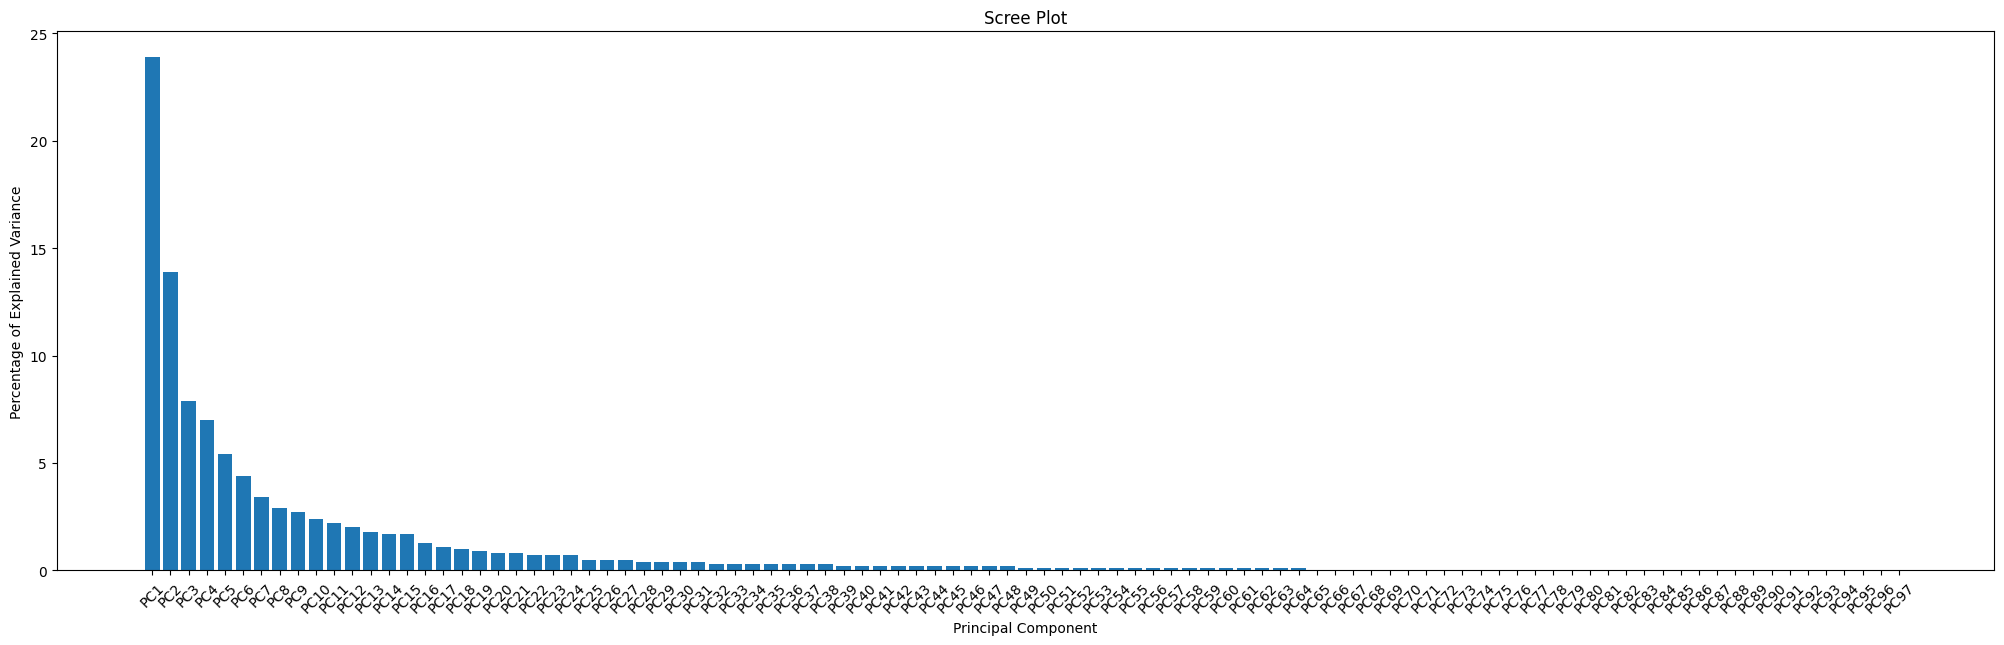

In [104]:
pca=PCA()
pca.set_output(transform='pandas')
pca.fit(X_train)
pca_data=pca.transform(X_train)
per_var=np.round(pca.explained_variance_ratio_*100,decimals=1)
labels=["PC"+str(i) for i in range(1,len(per_var)+1)]

plt.figure(figsize=(25, 7))
plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.xticks(rotation=45)
plt.show()


In [112]:
#till PCA20 
pca=PCA(n_components=50)
pca.set_output(transform='pandas')
X_pca_train=pca.fit_transform(X_train)
X_pca_test=pca.transform(X_test)


In [113]:
#Training
gbr.fit(X_pca_train,y_train)
xgboost.fit(X_pca_train,y_train)
lightgbm.fit(X_pca_train,y_train)
sgd_gs.best_estimator_.fit(X_pca_train,y_train)
cat_gs.best_estimator_.fit(X_pca_train,y_train)
ada_gs.best_estimator_.fit(X_pca_train,y_train)
#Testing
print('GradientBoosting')
print(gbr.score(X_pca_test,y_test))

print('xgboost')
print(xgboost.score(X_pca_test,y_test))

print('lightgbm')
print(lightgbm.score(X_pca_test,y_test))

print('sgd')
print(sgd_gs.best_estimator_.score(X_pca_test,y_test))

print('catboost')
print(cat_gs.best_estimator_.score(X_pca_test,y_test))

print('adaboost')
print(ada_gs.best_estimator_.score(X_pca_test,y_test))


0:	learn: 73415.6335946	total: 4.6ms	remaining: 4.59s
1:	learn: 71799.8325014	total: 8.3ms	remaining: 4.14s
2:	learn: 70156.5406665	total: 11.2ms	remaining: 3.74s
3:	learn: 68452.6522957	total: 14.1ms	remaining: 3.5s
4:	learn: 66691.0430056	total: 16.9ms	remaining: 3.35s
5:	learn: 65003.7518626	total: 20.8ms	remaining: 3.45s
6:	learn: 63474.7130978	total: 23.5ms	remaining: 3.34s
7:	learn: 62138.9830836	total: 26.2ms	remaining: 3.25s
8:	learn: 61106.6630457	total: 29ms	remaining: 3.19s
9:	learn: 59994.0046196	total: 31.4ms	remaining: 3.11s
10:	learn: 58577.8375769	total: 34.1ms	remaining: 3.06s
11:	learn: 57365.9329931	total: 37.3ms	remaining: 3.07s
12:	learn: 56367.4174847	total: 40ms	remaining: 3.04s
13:	learn: 55352.7781305	total: 42.9ms	remaining: 3.02s
14:	learn: 54314.4217948	total: 45.4ms	remaining: 2.98s
15:	learn: 53241.4982513	total: 48ms	remaining: 2.95s
16:	learn: 52404.2681999	total: 50.7ms	remaining: 2.93s
17:	learn: 51476.3497933	total: 53.5ms	remaining: 2.92s
18:	learn: 

In [115]:
sr_cv.best_estimator_.fit(X_pca_train,y_train)
print('StackingRegressor')
sr_cv.best_estimator_.score(X_pca_test,y_test)

0:	learn: 74911.3725901	total: 996us	remaining: 996ms
1:	learn: 74346.7446245	total: 1.95ms	remaining: 971ms
2:	learn: 73792.7789371	total: 2.74ms	remaining: 911ms
3:	learn: 73238.3492310	total: 3.56ms	remaining: 886ms
4:	learn: 72707.4042599	total: 4.37ms	remaining: 869ms
5:	learn: 72173.5802115	total: 5.2ms	remaining: 862ms
6:	learn: 71641.5716580	total: 6.07ms	remaining: 861ms
7:	learn: 71113.6475699	total: 6.85ms	remaining: 850ms
8:	learn: 70605.6619706	total: 7.69ms	remaining: 847ms
9:	learn: 70089.5297590	total: 8.5ms	remaining: 841ms
10:	learn: 69592.3227274	total: 9.45ms	remaining: 850ms
11:	learn: 69096.2699471	total: 10.4ms	remaining: 853ms
12:	learn: 68621.6885770	total: 11.2ms	remaining: 851ms
13:	learn: 68131.1282852	total: 12.2ms	remaining: 857ms
14:	learn: 67661.2285343	total: 13.1ms	remaining: 858ms
15:	learn: 67185.2334967	total: 13.9ms	remaining: 855ms
16:	learn: 66722.7961002	total: 14.8ms	remaining: 855ms
17:	learn: 66259.7474221	total: 15.7ms	remaining: 855ms
18:	l

0.888671019833376

Better without PCA Reduction

In [142]:
#Final prediction 
X_finaltest = pipeline.transform(df_test)
y_finaltest = pd.read_csv("sample_submission.csv")
y_finaltest=y_finaltest.iloc[:,1]



In [129]:
#Training
gbr.fit(X_pre,y)
xgboost.fit(X_pre,y)
lightgbm.fit(X_pre,y)
sgd_gs.best_estimator_.fit(X_pre,y)
cat_gs.best_estimator_.fit(X_pre,y)
ada_gs.best_estimator_.fit(X_pre,y)

#Testing
print('GradientBoosting')
print(gbr.score(X_finaltest,y_finaltest))

print('xgboost')
print(xgboost.score(X_finaltest,y_finaltest))

print('lightgbm')
print(lightgbm.score(X_finaltest,y_finaltest))

print('sgd')
print(sgd_gs.best_estimator_.score(X_finaltest,y_finaltest))

print('catboost')
print(cat_gs.best_estimator_.score(X_finaltest,y_finaltest))

print('adaboost')
print(ada_gs.best_estimator_.score(X_finaltest,y_finaltest))


0:	learn: 72808.0692158	total: 1.54ms	remaining: 1.54s
1:	learn: 70590.2133750	total: 3.17ms	remaining: 1.58s
2:	learn: 68448.1960740	total: 4.77ms	remaining: 1.58s
3:	learn: 66422.8119176	total: 6.16ms	remaining: 1.53s
4:	learn: 64463.2738519	total: 7.32ms	remaining: 1.46s
5:	learn: 62476.8022995	total: 8.26ms	remaining: 1.37s
6:	learn: 60700.5333974	total: 9.49ms	remaining: 1.35s
7:	learn: 59140.2605563	total: 10.7ms	remaining: 1.33s
8:	learn: 57460.5151678	total: 12ms	remaining: 1.32s
9:	learn: 55965.7919502	total: 13.2ms	remaining: 1.3s
10:	learn: 54406.1871155	total: 14.4ms	remaining: 1.29s
11:	learn: 52904.7739090	total: 15.6ms	remaining: 1.28s
12:	learn: 51481.0098340	total: 16.8ms	remaining: 1.28s
13:	learn: 50096.4347283	total: 18ms	remaining: 1.27s
14:	learn: 48710.8786273	total: 19.5ms	remaining: 1.28s
15:	learn: 47437.3476773	total: 20.8ms	remaining: 1.28s
16:	learn: 46346.4955883	total: 22.1ms	remaining: 1.28s
17:	learn: 45329.2874156	total: 23.3ms	remaining: 1.27s
18:	lea

In [130]:
sr_cv.best_estimator_.fit(X_pre,y)
print('StackingRegressor')
sr_cv.best_estimator_.score(X_finaltest,y_finaltest)

0:	learn: 74531.1728358	total: 1.06ms	remaining: 1.06s
1:	learn: 73935.0129356	total: 1.99ms	remaining: 993ms
2:	learn: 73342.7070381	total: 2.82ms	remaining: 936ms
3:	learn: 72747.3428918	total: 3.61ms	remaining: 899ms
4:	learn: 72171.4721667	total: 4.47ms	remaining: 889ms
5:	learn: 71595.3079498	total: 5.31ms	remaining: 879ms
6:	learn: 71030.0240009	total: 6.16ms	remaining: 874ms
7:	learn: 70471.9653547	total: 7.12ms	remaining: 882ms
8:	learn: 69935.3387074	total: 8.06ms	remaining: 888ms
9:	learn: 69383.9775508	total: 8.94ms	remaining: 885ms
10:	learn: 68835.2624539	total: 9.8ms	remaining: 881ms
11:	learn: 68298.1617264	total: 10.7ms	remaining: 877ms
12:	learn: 67764.4958521	total: 11.5ms	remaining: 872ms
13:	learn: 67227.7520931	total: 12.3ms	remaining: 867ms
14:	learn: 66726.4515888	total: 13.1ms	remaining: 862ms
15:	learn: 66212.4536294	total: 14ms	remaining: 860ms
16:	learn: 65704.5556871	total: 14.8ms	remaining: 857ms
17:	learn: 65190.2995326	total: 15.7ms	remaining: 855ms
18:	l

-19.92258353287385

Final Results for Test df given

In [148]:
y_pred=sr_cv.best_estimator_.predict(X_finaltest)
Id=pd.Series(range(1461,1461+y_pred.shape[0]))
df=pd.DataFrame({'Id':Id,'SalePrice':y_pred})
df.to_csv("sub.csv",index=False)

(1459, 2)